# EuroSAT Dataset Applying Pre-trained CNN MobileNetV3 (small)

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: HerbaceousVegetation --> count: 3000
class: AnnualCrop --> count: 3000
class: Forest --> count: 3000
class: SeaLake --> count: 3000
class: Residential --> count: 3000
class: PermanentCrop --> count: 2500
class: Industrial --> count: 2500
class: River --> count: 2500
class: Highway --> count: 2500
class: Pasture --> count: 2000


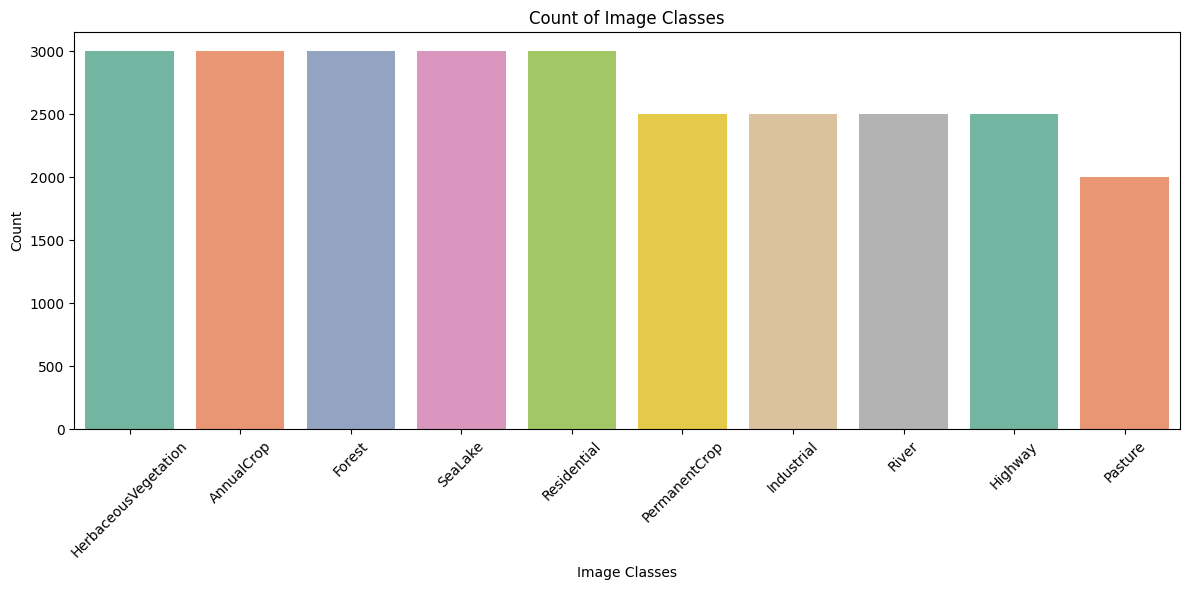

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

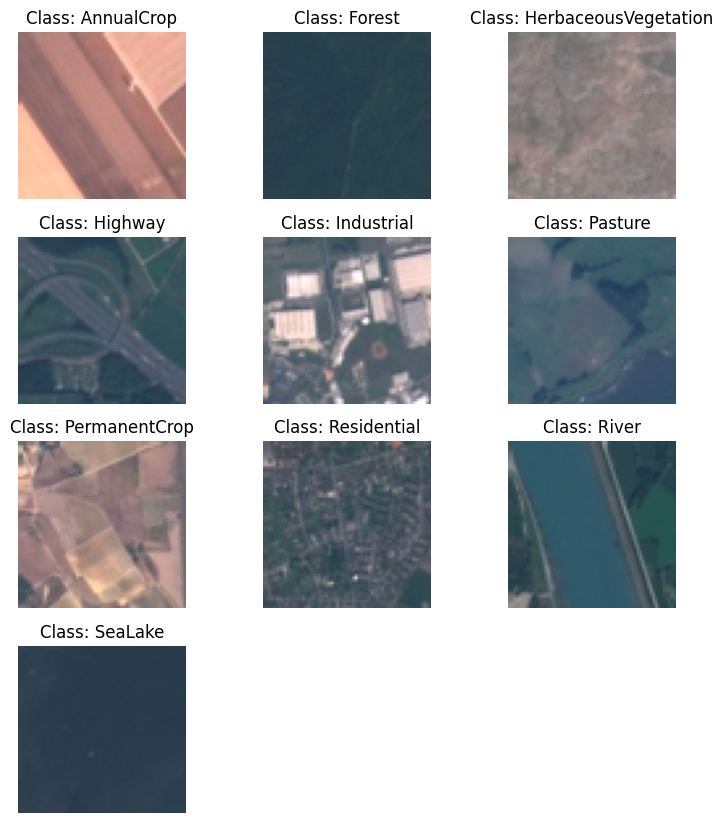

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

### Label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [15]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])
    
    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (ResNet)

In [16]:
total_class = 10
learning_rate = 0.0001

model = models.mobilenet_v3_small(pretrained=False)

model.classifier[3] = nn.Linear(model.classifier[3].in_features, total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

### Training

In [17]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 296/296 [01:30<00:00,  3.27it/s, acc=0.497, loss=1.37]

Training Loss: 1.371 Acc: 0.497


Validation Loss: 2.544 Acc: 0.074
✅ Best model saved at epoch 1 with validation accuracy: 0.074


Epoch 2/150: 100%|██████████| 296/296 [01:00<00:00,  4.86it/s, acc=0.677, loss=0.892]

Training Loss: 0.892 Acc: 0.677


Validation Loss: 2.671 Acc: 0.198
✅ Best model saved at epoch 2 with validation accuracy: 0.198


Epoch 3/150: 100%|██████████| 296/296 [00:57<00:00,  5.18it/s, acc=0.729, loss=0.757]

Training Loss: 0.757 Acc: 0.729


Validation Loss: 0.617 Acc: 0.782
✅ Best model saved at epoch 3 with validation accuracy: 0.782


Epoch 4/150: 100%|██████████| 296/296 [00:57<00:00,  5.18it/s, acc=0.754, loss=0.683]

Training Loss: 0.683 Acc: 0.754


Validation Loss: 0.585 Acc: 0.788
✅ Best model saved at epoch 4 with validation accuracy: 0.788


Epoch 5/150: 100%|██████████| 296/296 [01:01<00:00,  4.80it/s, acc=0.775, loss=0.63] 

Training Loss: 0.630 Acc: 0.775


Validation Loss: 0.572 Acc: 0.804
✅ Best model saved at epoch 5 with validation accuracy: 0.804


Epoch 6/150: 100%|██████████| 296/296 [00:59<00:00,  5.00it/s, acc=0.792, loss=0.593]

Training Loss: 0.593 Acc: 0.792


Validation Loss: 0.577 Acc: 0.803


Epoch 7/150: 100%|██████████| 296/296 [00:57<00:00,  5.18it/s, acc=0.807, loss=0.552]

Training Loss: 0.552 Acc: 0.807


Validation Loss: 0.514 Acc: 0.824
✅ Best model saved at epoch 7 with validation accuracy: 0.824


Epoch 8/150: 100%|██████████| 296/296 [01:02<00:00,  4.72it/s, acc=0.816, loss=0.525]

Training Loss: 0.525 Acc: 0.816


Validation Loss: 0.423 Acc: 0.858
✅ Best model saved at epoch 8 with validation accuracy: 0.858


Epoch 9/150: 100%|██████████| 296/296 [01:01<00:00,  4.85it/s, acc=0.825, loss=0.499]

Training Loss: 0.499 Acc: 0.825


Validation Loss: 0.417 Acc: 0.856


Epoch 10/150: 100%|██████████| 296/296 [00:59<00:00,  5.00it/s, acc=0.834, loss=0.476]

Training Loss: 0.476 Acc: 0.834


Validation Loss: 0.362 Acc: 0.876
✅ Best model saved at epoch 10 with validation accuracy: 0.876


Epoch 11/150: 100%|██████████| 296/296 [00:59<00:00,  5.00it/s, acc=0.848, loss=0.44] 

Training Loss: 0.440 Acc: 0.848


Validation Loss: 0.414 Acc: 0.855


Epoch 12/150: 100%|██████████| 296/296 [01:01<00:00,  4.84it/s, acc=0.852, loss=0.423]

Training Loss: 0.423 Acc: 0.852


Validation Loss: 0.339 Acc: 0.884
✅ Best model saved at epoch 12 with validation accuracy: 0.884


Epoch 13/150: 100%|██████████| 296/296 [01:00<00:00,  4.91it/s, acc=0.857, loss=0.416]

Training Loss: 0.416 Acc: 0.857


Validation Loss: 0.343 Acc: 0.887
✅ Best model saved at epoch 13 with validation accuracy: 0.887


Epoch 14/150: 100%|██████████| 296/296 [00:57<00:00,  5.13it/s, acc=0.863, loss=0.393]

Training Loss: 0.393 Acc: 0.863


Validation Loss: 0.316 Acc: 0.896
✅ Best model saved at epoch 14 with validation accuracy: 0.896


Epoch 15/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.869, loss=0.374]

Training Loss: 0.374 Acc: 0.869


Validation Loss: 0.392 Acc: 0.874


Epoch 16/150: 100%|██████████| 296/296 [00:59<00:00,  4.97it/s, acc=0.874, loss=0.355]

Training Loss: 0.355 Acc: 0.874


Validation Loss: 0.322 Acc: 0.891


Epoch 17/150: 100%|██████████| 296/296 [01:00<00:00,  4.87it/s, acc=0.881, loss=0.345]

Training Loss: 0.345 Acc: 0.881


Validation Loss: 0.284 Acc: 0.901
✅ Best model saved at epoch 17 with validation accuracy: 0.901


Epoch 18/150: 100%|██████████| 296/296 [00:59<00:00,  4.99it/s, acc=0.886, loss=0.329]

Training Loss: 0.329 Acc: 0.886


Validation Loss: 0.280 Acc: 0.909
✅ Best model saved at epoch 18 with validation accuracy: 0.909


Epoch 19/150: 100%|██████████| 296/296 [00:54<00:00,  5.46it/s, acc=0.891, loss=0.315]

Training Loss: 0.315 Acc: 0.891


Validation Loss: 0.274 Acc: 0.904


Epoch 20/150: 100%|██████████| 296/296 [00:53<00:00,  5.56it/s, acc=0.893, loss=0.312]

Training Loss: 0.312 Acc: 0.893


Validation Loss: 0.257 Acc: 0.915
✅ Best model saved at epoch 20 with validation accuracy: 0.915


Epoch 21/150: 100%|██████████| 296/296 [00:58<00:00,  5.10it/s, acc=0.894, loss=0.299]

Training Loss: 0.299 Acc: 0.894


Validation Loss: 0.273 Acc: 0.907


Epoch 22/150: 100%|██████████| 296/296 [00:53<00:00,  5.50it/s, acc=0.9, loss=0.292]  

Training Loss: 0.292 Acc: 0.900


Validation Loss: 0.239 Acc: 0.921
✅ Best model saved at epoch 22 with validation accuracy: 0.921


Epoch 23/150: 100%|██████████| 296/296 [00:57<00:00,  5.16it/s, acc=0.903, loss=0.272]

Training Loss: 0.272 Acc: 0.903


Validation Loss: 0.305 Acc: 0.901


Epoch 24/150: 100%|██████████| 296/296 [00:59<00:00,  4.99it/s, acc=0.905, loss=0.271]

Training Loss: 0.271 Acc: 0.905


Validation Loss: 0.269 Acc: 0.907


Epoch 25/150: 100%|██████████| 296/296 [00:59<00:00,  4.98it/s, acc=0.908, loss=0.266]

Training Loss: 0.266 Acc: 0.908


Validation Loss: 0.249 Acc: 0.917


Epoch 26/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.911, loss=0.258]

Training Loss: 0.258 Acc: 0.911


Validation Loss: 0.291 Acc: 0.908


Epoch 27/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.91, loss=0.255] 

Training Loss: 0.255 Acc: 0.910


Validation Loss: 0.304 Acc: 0.895


Epoch 28/150: 100%|██████████| 296/296 [01:00<00:00,  4.90it/s, acc=0.916, loss=0.24] 

Training Loss: 0.240 Acc: 0.916


Validation Loss: 0.227 Acc: 0.920


Epoch 29/150: 100%|██████████| 296/296 [00:57<00:00,  5.13it/s, acc=0.92, loss=0.229] 

Training Loss: 0.229 Acc: 0.920


Validation Loss: 0.238 Acc: 0.917


Epoch 30/150: 100%|██████████| 296/296 [00:56<00:00,  5.28it/s, acc=0.919, loss=0.229]

Training Loss: 0.229 Acc: 0.919


Validation Loss: 0.210 Acc: 0.929
✅ Best model saved at epoch 30 with validation accuracy: 0.929


Epoch 31/150: 100%|██████████| 296/296 [00:54<00:00,  5.42it/s, acc=0.922, loss=0.223]

Training Loss: 0.223 Acc: 0.922


Validation Loss: 0.210 Acc: 0.930
✅ Best model saved at epoch 31 with validation accuracy: 0.930


Epoch 32/150: 100%|██████████| 296/296 [00:58<00:00,  5.08it/s, acc=0.922, loss=0.22] 

Training Loss: 0.220 Acc: 0.922


Validation Loss: 0.211 Acc: 0.933
✅ Best model saved at epoch 32 with validation accuracy: 0.933


Epoch 33/150: 100%|██████████| 296/296 [00:53<00:00,  5.50it/s, acc=0.922, loss=0.217]

Training Loss: 0.217 Acc: 0.922


Validation Loss: 0.200 Acc: 0.932


Epoch 34/150: 100%|██████████| 296/296 [00:54<00:00,  5.47it/s, acc=0.924, loss=0.213]

Training Loss: 0.213 Acc: 0.924


Validation Loss: 0.204 Acc: 0.931


Epoch 35/150: 100%|██████████| 296/296 [01:02<00:00,  4.77it/s, acc=0.924, loss=0.213]

Training Loss: 0.213 Acc: 0.924


Validation Loss: 0.359 Acc: 0.894


Epoch 36/150: 100%|██████████| 296/296 [00:54<00:00,  5.46it/s, acc=0.931, loss=0.196]

Training Loss: 0.196 Acc: 0.931


Validation Loss: 0.193 Acc: 0.934
✅ Best model saved at epoch 36 with validation accuracy: 0.934


Epoch 37/150: 100%|██████████| 296/296 [00:56<00:00,  5.20it/s, acc=0.93, loss=0.199] 

Training Loss: 0.199 Acc: 0.930


Validation Loss: 0.185 Acc: 0.935
✅ Best model saved at epoch 37 with validation accuracy: 0.935


Epoch 38/150: 100%|██████████| 296/296 [00:57<00:00,  5.13it/s, acc=0.931, loss=0.192]

Training Loss: 0.192 Acc: 0.931


Validation Loss: 0.205 Acc: 0.930


Epoch 39/150: 100%|██████████| 296/296 [00:57<00:00,  5.14it/s, acc=0.934, loss=0.189]

Training Loss: 0.189 Acc: 0.934


Validation Loss: 0.178 Acc: 0.938
✅ Best model saved at epoch 39 with validation accuracy: 0.938


Epoch 40/150: 100%|██████████| 296/296 [00:52<00:00,  5.69it/s, acc=0.936, loss=0.186]

Training Loss: 0.186 Acc: 0.936


Validation Loss: 0.170 Acc: 0.943
✅ Best model saved at epoch 40 with validation accuracy: 0.943


Epoch 41/150: 100%|██████████| 296/296 [00:55<00:00,  5.29it/s, acc=0.936, loss=0.182]

Training Loss: 0.182 Acc: 0.936


Validation Loss: 0.191 Acc: 0.933


Epoch 42/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.938, loss=0.177]

Training Loss: 0.177 Acc: 0.938


Validation Loss: 0.209 Acc: 0.934


Epoch 43/150: 100%|██████████| 296/296 [00:56<00:00,  5.22it/s, acc=0.936, loss=0.177]

Training Loss: 0.177 Acc: 0.936


Validation Loss: 0.160 Acc: 0.948
✅ Best model saved at epoch 43 with validation accuracy: 0.948


Epoch 44/150: 100%|██████████| 296/296 [00:54<00:00,  5.44it/s, acc=0.944, loss=0.165]

Training Loss: 0.165 Acc: 0.944


Validation Loss: 0.177 Acc: 0.939


Epoch 45/150: 100%|██████████| 296/296 [00:53<00:00,  5.51it/s, acc=0.941, loss=0.17] 

Training Loss: 0.170 Acc: 0.941


Validation Loss: 0.271 Acc: 0.915


Epoch 46/150: 100%|██████████| 296/296 [00:55<00:00,  5.35it/s, acc=0.942, loss=0.169]

Training Loss: 0.169 Acc: 0.942


Validation Loss: 0.155 Acc: 0.949
✅ Best model saved at epoch 46 with validation accuracy: 0.949


Epoch 47/150: 100%|██████████| 296/296 [01:00<00:00,  4.88it/s, acc=0.941, loss=0.165]

Training Loss: 0.165 Acc: 0.941


Validation Loss: 0.187 Acc: 0.939


Epoch 48/150: 100%|██████████| 296/296 [00:56<00:00,  5.19it/s, acc=0.943, loss=0.16] 

Training Loss: 0.160 Acc: 0.943


Validation Loss: 0.181 Acc: 0.944


Epoch 49/150: 100%|██████████| 296/296 [00:59<00:00,  4.94it/s, acc=0.941, loss=0.166]

Training Loss: 0.166 Acc: 0.941


Validation Loss: 0.202 Acc: 0.930


Epoch 50/150: 100%|██████████| 296/296 [00:54<00:00,  5.48it/s, acc=0.944, loss=0.16] 

Training Loss: 0.160 Acc: 0.944


Validation Loss: 0.162 Acc: 0.948


Epoch 51/150: 100%|██████████| 296/296 [00:57<00:00,  5.16it/s, acc=0.944, loss=0.154]

Training Loss: 0.154 Acc: 0.944


Validation Loss: 0.155 Acc: 0.946


Epoch 52/150: 100%|██████████| 296/296 [00:54<00:00,  5.45it/s, acc=0.946, loss=0.154]

Training Loss: 0.154 Acc: 0.946


Validation Loss: 0.186 Acc: 0.939


Epoch 53/150: 100%|██████████| 296/296 [00:59<00:00,  5.00it/s, acc=0.946, loss=0.151]

Training Loss: 0.151 Acc: 0.946


Validation Loss: 0.175 Acc: 0.942


Epoch 54/150: 100%|██████████| 296/296 [00:56<00:00,  5.27it/s, acc=0.947, loss=0.148]

Training Loss: 0.148 Acc: 0.947


Validation Loss: 0.155 Acc: 0.950
✅ Best model saved at epoch 54 with validation accuracy: 0.950


Epoch 55/150: 100%|██████████| 296/296 [00:54<00:00,  5.45it/s, acc=0.946, loss=0.148]

Training Loss: 0.148 Acc: 0.946


Validation Loss: 0.211 Acc: 0.934


Epoch 56/150: 100%|██████████| 296/296 [00:53<00:00,  5.56it/s, acc=0.947, loss=0.143]

Training Loss: 0.143 Acc: 0.947


Validation Loss: 0.170 Acc: 0.946


Epoch 57/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.951, loss=0.14] 

Training Loss: 0.140 Acc: 0.951


Validation Loss: 0.200 Acc: 0.940


Epoch 58/150: 100%|██████████| 296/296 [00:53<00:00,  5.55it/s, acc=0.949, loss=0.146]

Training Loss: 0.146 Acc: 0.949


Validation Loss: 0.186 Acc: 0.941


Epoch 59/150: 100%|██████████| 296/296 [00:56<00:00,  5.21it/s, acc=0.95, loss=0.139] 

Training Loss: 0.139 Acc: 0.950


Validation Loss: 0.132 Acc: 0.955
✅ Best model saved at epoch 59 with validation accuracy: 0.955


Epoch 60/150: 100%|██████████| 296/296 [00:56<00:00,  5.25it/s, acc=0.952, loss=0.133]

Training Loss: 0.133 Acc: 0.952


Validation Loss: 0.168 Acc: 0.940


Epoch 61/150: 100%|██████████| 296/296 [00:56<00:00,  5.25it/s, acc=0.953, loss=0.133]

Training Loss: 0.133 Acc: 0.953


Validation Loss: 0.191 Acc: 0.935


Epoch 62/150: 100%|██████████| 296/296 [00:58<00:00,  5.07it/s, acc=0.952, loss=0.133]

Training Loss: 0.133 Acc: 0.952


Validation Loss: 0.172 Acc: 0.945


Epoch 63/150: 100%|██████████| 296/296 [00:56<00:00,  5.20it/s, acc=0.952, loss=0.134]

Training Loss: 0.134 Acc: 0.952


Validation Loss: 0.152 Acc: 0.954


Epoch 64/150: 100%|██████████| 296/296 [00:54<00:00,  5.43it/s, acc=0.954, loss=0.127]

Training Loss: 0.127 Acc: 0.954


Validation Loss: 0.140 Acc: 0.954


Epoch 65/150: 100%|██████████| 296/296 [00:57<00:00,  5.12it/s, acc=0.954, loss=0.124]

Training Loss: 0.124 Acc: 0.954


Validation Loss: 0.141 Acc: 0.957
✅ Best model saved at epoch 65 with validation accuracy: 0.957


Epoch 66/150: 100%|██████████| 296/296 [00:57<00:00,  5.11it/s, acc=0.955, loss=0.123]

Training Loss: 0.123 Acc: 0.955


Validation Loss: 0.143 Acc: 0.953


Epoch 67/150: 100%|██████████| 296/296 [00:59<00:00,  4.97it/s, acc=0.956, loss=0.126]

Training Loss: 0.126 Acc: 0.956


Validation Loss: 0.142 Acc: 0.955


Epoch 68/150: 100%|██████████| 296/296 [00:59<00:00,  4.96it/s, acc=0.955, loss=0.124]

Training Loss: 0.124 Acc: 0.955


Validation Loss: 0.156 Acc: 0.953


Epoch 69/150: 100%|██████████| 296/296 [00:59<00:00,  4.94it/s, acc=0.956, loss=0.122]

Training Loss: 0.122 Acc: 0.956


Validation Loss: 0.142 Acc: 0.955


Epoch 70/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.955, loss=0.125]

Training Loss: 0.125 Acc: 0.955


Validation Loss: 0.213 Acc: 0.935


Epoch 71/150: 100%|██████████| 296/296 [00:56<00:00,  5.25it/s, acc=0.96, loss=0.112] 

Training Loss: 0.112 Acc: 0.960


Validation Loss: 0.146 Acc: 0.957


Epoch 72/150: 100%|██████████| 296/296 [00:56<00:00,  5.27it/s, acc=0.958, loss=0.118]

Training Loss: 0.118 Acc: 0.958


Validation Loss: 0.157 Acc: 0.948


Epoch 73/150: 100%|██████████| 296/296 [01:00<00:00,  4.89it/s, acc=0.959, loss=0.114]

Training Loss: 0.114 Acc: 0.959


Validation Loss: 0.126 Acc: 0.960
✅ Best model saved at epoch 73 with validation accuracy: 0.960


Epoch 74/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.96, loss=0.113] 

Training Loss: 0.113 Acc: 0.960


Validation Loss: 0.167 Acc: 0.946


Epoch 75/150: 100%|██████████| 296/296 [00:56<00:00,  5.24it/s, acc=0.96, loss=0.11]  

Training Loss: 0.110 Acc: 0.960


Validation Loss: 0.178 Acc: 0.947


Epoch 76/150: 100%|██████████| 296/296 [00:54<00:00,  5.46it/s, acc=0.959, loss=0.114]

Training Loss: 0.114 Acc: 0.959


Validation Loss: 0.130 Acc: 0.961
✅ Best model saved at epoch 76 with validation accuracy: 0.961


Epoch 77/150: 100%|██████████| 296/296 [00:59<00:00,  4.99it/s, acc=0.961, loss=0.109]

Training Loss: 0.109 Acc: 0.961


Validation Loss: 0.140 Acc: 0.956


Epoch 78/150: 100%|██████████| 296/296 [01:00<00:00,  4.88it/s, acc=0.961, loss=0.109]

Training Loss: 0.109 Acc: 0.961


Validation Loss: 0.159 Acc: 0.949


Epoch 79/150: 100%|██████████| 296/296 [00:57<00:00,  5.17it/s, acc=0.961, loss=0.106]

Training Loss: 0.106 Acc: 0.961


Validation Loss: 0.166 Acc: 0.949


Epoch 80/150: 100%|██████████| 296/296 [00:54<00:00,  5.47it/s, acc=0.96, loss=0.11]  

Training Loss: 0.110 Acc: 0.960


Validation Loss: 0.173 Acc: 0.942


Epoch 81/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.963, loss=0.107]

Training Loss: 0.107 Acc: 0.963


Validation Loss: 0.136 Acc: 0.959


Epoch 82/150: 100%|██████████| 296/296 [00:54<00:00,  5.44it/s, acc=0.963, loss=0.103] 

Training Loss: 0.103 Acc: 0.963


Validation Loss: 0.130 Acc: 0.961
✅ Best model saved at epoch 82 with validation accuracy: 0.961


Epoch 83/150: 100%|██████████| 296/296 [00:54<00:00,  5.46it/s, acc=0.964, loss=0.0981]

Training Loss: 0.098 Acc: 0.964


Validation Loss: 0.133 Acc: 0.958


Epoch 84/150: 100%|██████████| 296/296 [00:56<00:00,  5.27it/s, acc=0.963, loss=0.101] 

Training Loss: 0.101 Acc: 0.963


Validation Loss: 0.134 Acc: 0.960


Epoch 85/150: 100%|██████████| 296/296 [00:55<00:00,  5.30it/s, acc=0.962, loss=0.105]

Training Loss: 0.105 Acc: 0.962


Validation Loss: 0.183 Acc: 0.942


Epoch 86/150: 100%|██████████| 296/296 [00:56<00:00,  5.20it/s, acc=0.961, loss=0.107]

Training Loss: 0.107 Acc: 0.961


Validation Loss: 0.148 Acc: 0.951


Epoch 87/150: 100%|██████████| 296/296 [00:57<00:00,  5.17it/s, acc=0.966, loss=0.0964]

Training Loss: 0.096 Acc: 0.966


Validation Loss: 0.130 Acc: 0.960


Epoch 88/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.964, loss=0.0973]

Training Loss: 0.097 Acc: 0.964


Validation Loss: 0.216 Acc: 0.936


Epoch 89/150: 100%|██████████| 296/296 [00:56<00:00,  5.22it/s, acc=0.966, loss=0.097] 

Training Loss: 0.097 Acc: 0.966


Validation Loss: 0.179 Acc: 0.946


Epoch 90/150: 100%|██████████| 296/296 [00:53<00:00,  5.56it/s, acc=0.966, loss=0.0967]

Training Loss: 0.097 Acc: 0.966


Validation Loss: 0.151 Acc: 0.954


Epoch 91/150: 100%|██████████| 296/296 [00:55<00:00,  5.34it/s, acc=0.966, loss=0.0961]

Training Loss: 0.096 Acc: 0.966


Validation Loss: 0.190 Acc: 0.942


Epoch 92/150: 100%|██████████| 296/296 [00:52<00:00,  5.69it/s, acc=0.969, loss=0.0886]

Training Loss: 0.089 Acc: 0.969


Validation Loss: 0.147 Acc: 0.954


Epoch 93/150: 100%|██████████| 296/296 [00:55<00:00,  5.35it/s, acc=0.968, loss=0.0888]

Training Loss: 0.089 Acc: 0.968


Validation Loss: 0.134 Acc: 0.958


Epoch 94/150: 100%|██████████| 296/296 [00:54<00:00,  5.39it/s, acc=0.968, loss=0.0901]

Training Loss: 0.090 Acc: 0.968


Validation Loss: 0.154 Acc: 0.955


Epoch 95/150: 100%|██████████| 296/296 [00:57<00:00,  5.16it/s, acc=0.969, loss=0.086] 

Training Loss: 0.086 Acc: 0.969


Validation Loss: 0.171 Acc: 0.949


Epoch 96/150: 100%|██████████| 296/296 [00:55<00:00,  5.38it/s, acc=0.968, loss=0.089] 

Training Loss: 0.089 Acc: 0.968


Validation Loss: 0.161 Acc: 0.952


Epoch 97/150: 100%|██████████| 296/296 [00:53<00:00,  5.53it/s, acc=0.968, loss=0.0874]

Training Loss: 0.087 Acc: 0.968


Validation Loss: 0.171 Acc: 0.950


Epoch 98/150: 100%|██████████| 296/296 [00:57<00:00,  5.16it/s, acc=0.969, loss=0.0857]

Training Loss: 0.086 Acc: 0.969


Validation Loss: 0.130 Acc: 0.962
✅ Best model saved at epoch 98 with validation accuracy: 0.962


Epoch 99/150: 100%|██████████| 296/296 [00:54<00:00,  5.38it/s, acc=0.967, loss=0.0895]

Training Loss: 0.089 Acc: 0.967


Validation Loss: 0.143 Acc: 0.959


Epoch 100/150: 100%|██████████| 296/296 [00:57<00:00,  5.17it/s, acc=0.968, loss=0.0866]

Training Loss: 0.087 Acc: 0.968


Validation Loss: 0.126 Acc: 0.960


Epoch 101/150: 100%|██████████| 296/296 [00:54<00:00,  5.40it/s, acc=0.968, loss=0.0857]

Training Loss: 0.086 Acc: 0.968


Validation Loss: 0.143 Acc: 0.958


Epoch 102/150: 100%|██████████| 296/296 [00:57<00:00,  5.13it/s, acc=0.967, loss=0.0904]

Training Loss: 0.090 Acc: 0.967


Validation Loss: 0.144 Acc: 0.955


Epoch 103/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.971, loss=0.0817]

Training Loss: 0.082 Acc: 0.971


Validation Loss: 0.153 Acc: 0.955


Epoch 104/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.972, loss=0.0777]

Training Loss: 0.078 Acc: 0.972


Validation Loss: 0.147 Acc: 0.957


Epoch 105/150: 100%|██████████| 296/296 [01:01<00:00,  4.85it/s, acc=0.972, loss=0.0789]

Training Loss: 0.079 Acc: 0.972


Validation Loss: 0.138 Acc: 0.958


Epoch 106/150: 100%|██████████| 296/296 [00:54<00:00,  5.41it/s, acc=0.971, loss=0.0797]

Training Loss: 0.080 Acc: 0.971


Validation Loss: 0.151 Acc: 0.961


Epoch 107/150: 100%|██████████| 296/296 [00:56<00:00,  5.26it/s, acc=0.971, loss=0.0806]

Training Loss: 0.081 Acc: 0.971


Validation Loss: 0.156 Acc: 0.957


Epoch 108/150: 100%|██████████| 296/296 [00:54<00:00,  5.41it/s, acc=0.971, loss=0.0813]

Training Loss: 0.081 Acc: 0.971


Validation Loss: 0.169 Acc: 0.951


Epoch 109/150: 100%|██████████| 296/296 [00:58<00:00,  5.08it/s, acc=0.971, loss=0.079] 

Training Loss: 0.079 Acc: 0.971


Validation Loss: 0.159 Acc: 0.955


Epoch 110/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.973, loss=0.0796]

Training Loss: 0.080 Acc: 0.973


Validation Loss: 0.141 Acc: 0.958


Epoch 111/150: 100%|██████████| 296/296 [00:55<00:00,  5.37it/s, acc=0.973, loss=0.074] 

Training Loss: 0.074 Acc: 0.973


Validation Loss: 0.144 Acc: 0.963
✅ Best model saved at epoch 111 with validation accuracy: 0.963


Epoch 112/150: 100%|██████████| 296/296 [00:52<00:00,  5.63it/s, acc=0.974, loss=0.0727]

Training Loss: 0.073 Acc: 0.974


Validation Loss: 0.142 Acc: 0.956


Epoch 113/150: 100%|██████████| 296/296 [00:55<00:00,  5.37it/s, acc=0.972, loss=0.077] 

Training Loss: 0.077 Acc: 0.972


Validation Loss: 0.152 Acc: 0.957


Epoch 114/150: 100%|██████████| 296/296 [00:56<00:00,  5.26it/s, acc=0.975, loss=0.0726]

Training Loss: 0.073 Acc: 0.975


Validation Loss: 0.185 Acc: 0.945


Epoch 115/150: 100%|██████████| 296/296 [00:55<00:00,  5.32it/s, acc=0.975, loss=0.0693]

Training Loss: 0.069 Acc: 0.975


Validation Loss: 0.141 Acc: 0.959


Epoch 116/150: 100%|██████████| 296/296 [00:55<00:00,  5.33it/s, acc=0.975, loss=0.0685]

Training Loss: 0.068 Acc: 0.975


Validation Loss: 0.158 Acc: 0.952


Epoch 117/150: 100%|██████████| 296/296 [00:56<00:00,  5.25it/s, acc=0.974, loss=0.0742]

Training Loss: 0.074 Acc: 0.974


Validation Loss: 0.136 Acc: 0.965
✅ Best model saved at epoch 117 with validation accuracy: 0.965


Epoch 118/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.975, loss=0.0692]

Training Loss: 0.069 Acc: 0.975


Validation Loss: 0.147 Acc: 0.960


Epoch 119/150: 100%|██████████| 296/296 [00:57<00:00,  5.18it/s, acc=0.975, loss=0.0679]

Training Loss: 0.068 Acc: 0.975


Validation Loss: 0.130 Acc: 0.963


Epoch 120/150: 100%|██████████| 296/296 [00:55<00:00,  5.35it/s, acc=0.975, loss=0.0672]

Training Loss: 0.067 Acc: 0.975


Validation Loss: 0.153 Acc: 0.958


Epoch 121/150: 100%|██████████| 296/296 [00:52<00:00,  5.62it/s, acc=0.974, loss=0.0723]

Training Loss: 0.072 Acc: 0.974


Validation Loss: 0.168 Acc: 0.952


Epoch 122/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.974, loss=0.0704]

Training Loss: 0.070 Acc: 0.974


Validation Loss: 0.168 Acc: 0.947


Epoch 123/150: 100%|██████████| 296/296 [01:01<00:00,  4.80it/s, acc=0.973, loss=0.0713]

Training Loss: 0.071 Acc: 0.973


Validation Loss: 0.147 Acc: 0.957


Epoch 124/150: 100%|██████████| 296/296 [00:54<00:00,  5.43it/s, acc=0.976, loss=0.0662]

Training Loss: 0.066 Acc: 0.976


Validation Loss: 0.146 Acc: 0.957


Epoch 125/150: 100%|██████████| 296/296 [00:59<00:00,  4.99it/s, acc=0.976, loss=0.0666]

Training Loss: 0.067 Acc: 0.976


Validation Loss: 0.171 Acc: 0.955


Epoch 126/150: 100%|██████████| 296/296 [01:00<00:00,  4.91it/s, acc=0.978, loss=0.0627]

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.165 Acc: 0.956


Epoch 127/150: 100%|██████████| 296/296 [00:56<00:00,  5.28it/s, acc=0.975, loss=0.0665]

Training Loss: 0.066 Acc: 0.975


Validation Loss: 0.153 Acc: 0.958


Epoch 128/150: 100%|██████████| 296/296 [01:01<00:00,  4.79it/s, acc=0.976, loss=0.066] 

Training Loss: 0.066 Acc: 0.976


Validation Loss: 0.173 Acc: 0.951


Epoch 129/150: 100%|██████████| 296/296 [00:54<00:00,  5.40it/s, acc=0.979, loss=0.0598]

Training Loss: 0.060 Acc: 0.979


Validation Loss: 0.163 Acc: 0.949


Epoch 130/150: 100%|██████████| 296/296 [01:00<00:00,  4.86it/s, acc=0.977, loss=0.0663]

Training Loss: 0.066 Acc: 0.977


Validation Loss: 0.148 Acc: 0.960


Epoch 131/150: 100%|██████████| 296/296 [00:54<00:00,  5.39it/s, acc=0.978, loss=0.0613]

Training Loss: 0.061 Acc: 0.978


Validation Loss: 0.185 Acc: 0.948


Epoch 132/150: 100%|██████████| 296/296 [00:57<00:00,  5.11it/s, acc=0.978, loss=0.0603]

Training Loss: 0.060 Acc: 0.978


Validation Loss: 0.150 Acc: 0.957


Epoch 133/150: 100%|██████████| 296/296 [00:52<00:00,  5.69it/s, acc=0.976, loss=0.0661]

Training Loss: 0.066 Acc: 0.976


Validation Loss: 0.148 Acc: 0.957


Epoch 134/150: 100%|██████████| 296/296 [00:53<00:00,  5.56it/s, acc=0.979, loss=0.0614]

Training Loss: 0.061 Acc: 0.979


Validation Loss: 0.148 Acc: 0.959


Epoch 135/150: 100%|██████████| 296/296 [00:56<00:00,  5.25it/s, acc=0.978, loss=0.0632]

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.142 Acc: 0.962


Epoch 136/150: 100%|██████████| 296/296 [00:55<00:00,  5.29it/s, acc=0.977, loss=0.0584]

Training Loss: 0.058 Acc: 0.977


Validation Loss: 0.152 Acc: 0.959


Epoch 137/150: 100%|██████████| 296/296 [00:54<00:00,  5.42it/s, acc=0.978, loss=0.0627]

Training Loss: 0.063 Acc: 0.978


Validation Loss: 0.160 Acc: 0.961


Epoch 138/150: 100%|██████████| 296/296 [00:52<00:00,  5.67it/s, acc=0.976, loss=0.065] 

Training Loss: 0.065 Acc: 0.976


Validation Loss: 0.129 Acc: 0.963


Epoch 139/150: 100%|██████████| 296/296 [00:52<00:00,  5.64it/s, acc=0.978, loss=0.0607]

Training Loss: 0.061 Acc: 0.978


Validation Loss: 0.141 Acc: 0.962


Epoch 140/150: 100%|██████████| 296/296 [00:58<00:00,  5.08it/s, acc=0.981, loss=0.0548]

Training Loss: 0.055 Acc: 0.981


Validation Loss: 0.213 Acc: 0.948


Epoch 141/150: 100%|██████████| 296/296 [00:54<00:00,  5.41it/s, acc=0.981, loss=0.0546]

Training Loss: 0.055 Acc: 0.981


Validation Loss: 0.141 Acc: 0.961


Epoch 142/150: 100%|██████████| 296/296 [00:53<00:00,  5.58it/s, acc=0.98, loss=0.0544] 

Training Loss: 0.054 Acc: 0.980


Validation Loss: 0.159 Acc: 0.956


Epoch 143/150: 100%|██████████| 296/296 [00:55<00:00,  5.37it/s, acc=0.98, loss=0.0553] 

Training Loss: 0.055 Acc: 0.980


Validation Loss: 0.166 Acc: 0.959


Epoch 144/150: 100%|██████████| 296/296 [00:52<00:00,  5.60it/s, acc=0.981, loss=0.0546]

Training Loss: 0.055 Acc: 0.981


Validation Loss: 0.146 Acc: 0.959


Epoch 145/150: 100%|██████████| 296/296 [00:56<00:00,  5.22it/s, acc=0.98, loss=0.0571] 

Training Loss: 0.057 Acc: 0.980


Validation Loss: 0.149 Acc: 0.965
✅ Best model saved at epoch 145 with validation accuracy: 0.965


Epoch 146/150: 100%|██████████| 296/296 [00:55<00:00,  5.29it/s, acc=0.981, loss=0.054] 

Training Loss: 0.054 Acc: 0.981


Validation Loss: 0.142 Acc: 0.961


Epoch 147/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.981, loss=0.0521]

Training Loss: 0.052 Acc: 0.981


Validation Loss: 0.162 Acc: 0.956


Epoch 148/150: 100%|██████████| 296/296 [00:57<00:00,  5.19it/s, acc=0.982, loss=0.0498]

Training Loss: 0.050 Acc: 0.982


Validation Loss: 0.167 Acc: 0.957


Epoch 149/150: 100%|██████████| 296/296 [00:55<00:00,  5.34it/s, acc=0.981, loss=0.0515]

Training Loss: 0.052 Acc: 0.981


Validation Loss: 0.139 Acc: 0.963


Epoch 150/150: 100%|██████████| 296/296 [00:52<00:00,  5.59it/s, acc=0.979, loss=0.0561]

Training Loss: 0.056 Acc: 0.979


Validation Loss: 0.138 Acc: 0.967
✅ Best model saved at epoch 150 with validation accuracy: 0.967
Training Time: 9671.25 seconds ---> 161.19 minutes


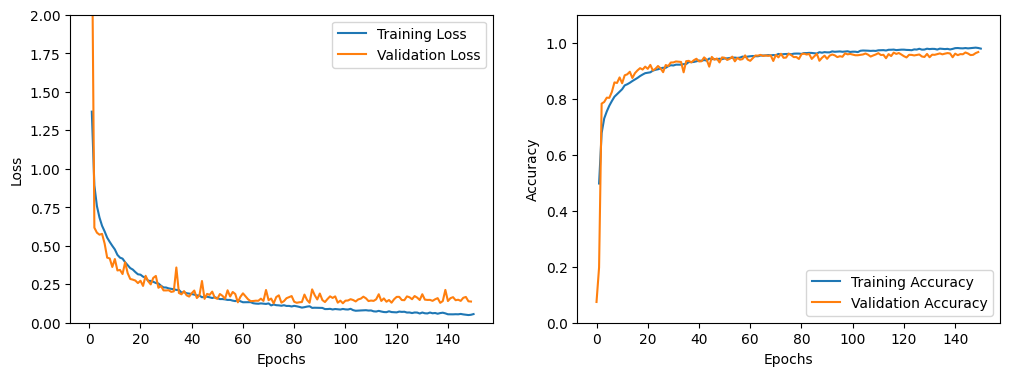

In [18]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [19]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 150) - Validation Loss: 0.141, Validation Accuracy: 0.963


In [20]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.963
Test Time: 15.28 seconds ---> 0.25 minutes


In [21]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       450
           1       0.98      1.00      0.99       450
           2       0.93      0.95      0.94       450
           3       0.96      0.99      0.97       375
           4       0.96      0.99      0.97       375
           5       0.96      0.98      0.97       300
           6       0.97      0.86      0.92       375
           7       0.97      0.99      0.98       450
           8       0.99      0.95      0.97       375
           9       0.99      0.98      0.99       450

    accuracy                           0.96      4050
   macro avg       0.96      0.96      0.96      4050
weighted avg       0.96      0.96      0.96      4050

Class 0 Accuracy: 0.944
Class 1 Accuracy: 0.998
Class 2 Accuracy: 0.949
Class 3 Accuracy: 0.976
Class 4 Accuracy: 0.995
Class 5 Accuracy: 0.963
Class 6 Accuracy: 0.875
Class 7 Accuracy: 0.989
Class 8 Accuracy: 0.957
Cl

### Confusion Matrix

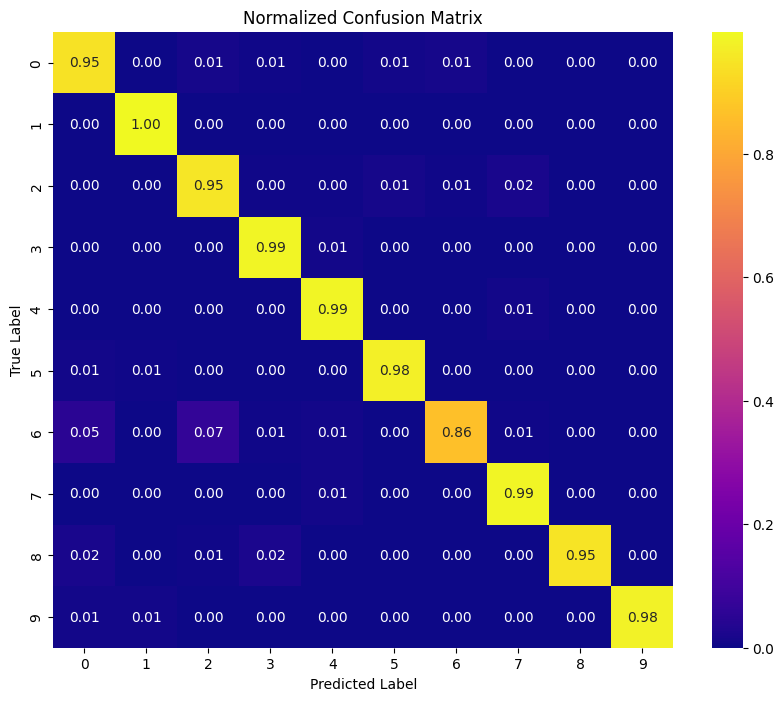

In [22]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC ROC Curve

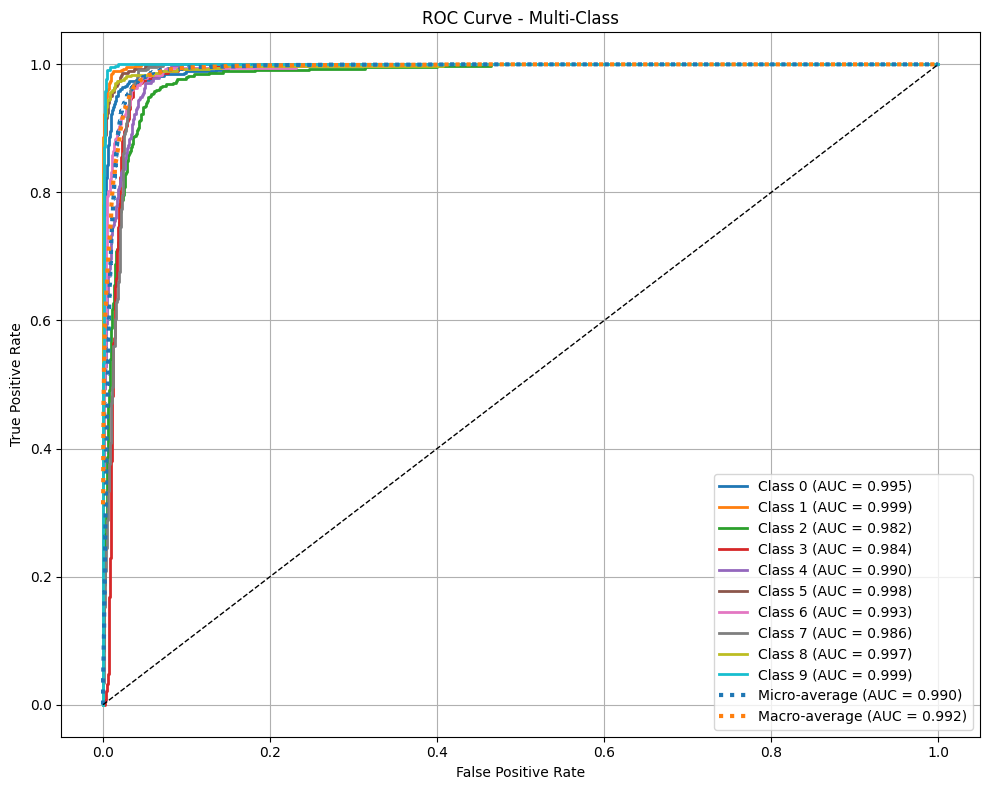

In [23]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()